In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
import scipy as sp

from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

In [3]:
##Steps to discretize events##

#generate parameters with uniform_param_generator
#generate simulated event (Python dictionary obect) (COULD ADD NOISE HERE?)  - seems to make more sense during generation
#convert simulated events to Event objects
#write this to our h5

#load h5 file and give it to discretizatio function
#loop through all events in h5 discretizing by taking evt.xyzs (COULD ADD NOISE HERE?)
#save discretized events to sparse csr_matrix

In [4]:
with open('/home/taylor/Documents/independent-research/req-files/config_e15503b_p.yml', 'r') as f:
    config = yaml.load(f)
    
beam_enu0 = config['beam_enu0']
#print(beam_enu0)
beam_mass = config['beam_mass']
beam_charge = config['beam_charge']
mass_num = config['mass_num']
max_beam_angle = (config['max_beam_angle']*math.pi)/180
#print(max_beam_angle)
beam_origin_z = config['beam_origin_z']

gas = pytpc.gases.InterpolatedGas('isobutane', 19.2)

# number of events to create
num_evts = 20

In [5]:
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)

In [6]:
p = next(pgen)

#p[0][0] = -0.00791423
#p[0][1] =  0.0030299
#p[0][2] = 0.56803276
#p[0][3] = 1.83097548
#p[0][4] =  0.11137931
#p[0][5] =  2.01473709

print(p)

(array([ -1.39057659e-03,  -8.30204629e-03,   8.04261148e-01,
         9.20388502e+00,   5.84399641e+00,   2.52914824e+00]), array([-0.00414054, -0.02471992, -0.99968584]))


In [7]:
sim = EventSimulator(config)

In [8]:
evt, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
print(len(evt))

79


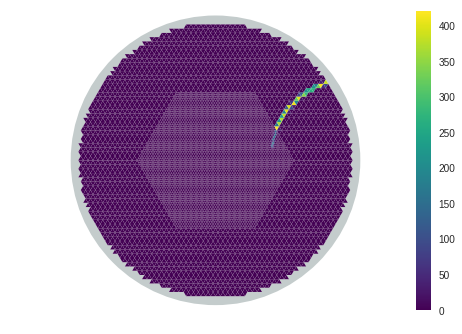

In [9]:
hits = np.zeros(10240)
for k, v in evt.items():
    hits[k] += v.max()
        
fig, sm = pad_plot(hits, scale='linear', cmap='viridis')
plt.colorbar(sm)

# Adding Random Noise

In [10]:
print(type(evt))

<class 'dict'>


In [11]:
print(evt.keys())

dict_keys([827, 830, 832, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1930, 1932, 1933, 1934, 1935, 1936, 1937, 1939, 2193, 2194, 2195, 2443, 2444, 2445, 2686, 2687, 2922, 2923, 3150, 3151, 3152, 3153, 3371, 3372, 3373, 3374, 3585, 3586, 3587, 3588, 3793, 3794, 3795, 3796, 3991, 3992, 3993, 3994, 4090, 4091, 4092, 4093, 4187, 4188, 4189, 4190, 4191, 4192, 4282, 4283, 4284])


In [12]:
#print(evt.get(148))

In [13]:
pyevt = sim.convert_event(evt)

In [14]:
print(pyevt)

Event 0, timestamp 0.
Contains 79 traces.


In [15]:
print(type(pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)))

<class 'numpy.ndarray'>


In [16]:
xyzs = pyevt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
print(len(xyzs))
print(xyzs.shape)
print(xyzs)

79
(79, 5)
[[  1.10435291e+02   2.40531859e+01   1.98000000e+02   2.00000000e+00
    8.27000000e+02]
 [  1.12889408e+02   2.27040337e+01   1.98500041e+02   7.96136775e+00
    8.30000000e+02]
 [  1.15343526e+02   2.40531859e+01   1.98908604e+02   7.96136775e+00
    8.32000000e+02]
 [  1.10435291e+02   2.69546901e+01   1.98908604e+02   7.96136775e+00
    1.11200000e+03]
 [  1.10435291e+02   3.25544985e+01   1.96908108e+02   7.95567991e+00
    1.11300000e+03]
 [  1.12889408e+02   3.12053464e+01   1.97000004e+02   8.18459803e+01
    1.11400000e+03]
 [  1.12889408e+02   2.83038422e+01   1.97969298e+02   1.29843860e+02
    1.11500000e+03]
 [  1.15343526e+02   3.25544985e+01   1.96542999e+02   1.26880098e+02
    1.11600000e+03]
 [  1.15343526e+02   2.69546901e+01   1.98051389e+02   7.16924005e+01
    1.11700000e+03]
 [  1.17797644e+02   2.83038422e+01   1.97486460e+02   1.09613677e+01
    1.11800000e+03]
 [  1.17797644e+02   3.12053464e+01   1.96500041e+02   1.59227355e+01
    1.11900000e+03]

In [17]:
#noise requirements:
#x and y: -DETECTOR_RADIUS < __ < +DETECTOR_RADIUS
#z: 0 < __ < DETECTOR_LENGTH

DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

In [18]:
#add new noise, not just randomly osciallate existing points - np.random.___()

In [19]:
num_noisepts = np.random.randint(20, 300,)    #20-300
print(num_noisepts)

67


In [20]:
#generate x and y based on random pad numbers
paddresses = np.random.randint(0,10240, (num_noisepts, 1))
print(paddresses.shape)

pads = pytpc.generate_pad_plane()
pcenters = pads.mean(1)

xys = pcenters[paddresses].reshape(num_noisepts, 2)
print(xys.shape)
#z and charge values are generated randomly in realistic ranges
zs = np.random.uniform(0, DETECTOR_LENGTH, (num_noisepts, 1))
print(zs.shape)

charges = np.random.uniform(1, 4000, (num_noisepts, 1))  #1-4000
print(charges.shape)

(67, 1)
(67, 2)
(67, 1)
(67, 1)


In [21]:
#note in discretization we do not need to return the pad addresses
noise_mat = np.hstack((xys, zs, charges, paddresses))

In [22]:
print(noise_mat)

[[  1.96329406e+01  -2.27040337e+01   4.55312775e+02   2.33836680e+03
    5.87300000e+03]
 [ -1.96329406e+01   1.33221098e+02   9.63458566e+02   3.86467238e+03
    3.89200000e+03]
 [ -5.39905866e+01   2.83038422e+01   9.49354065e+02   5.83671519e+02
    9.79000000e+02]
 [ -4.90823515e+00  -1.21818281e+02   9.19135537e+02   3.31438612e+03
    8.82300000e+03]
 [ -5.39905866e+01   7.37119097e+01   9.96405022e+02   2.58706035e+03
    2.30400000e+03]
 [  6.87152921e+01  -2.79990422e+00   6.89545991e+02   5.26447866e+02
    5.32600000e+03]
 [ -1.22705879e+02   2.23901767e+02   7.65458630e+02   2.50240342e+03
    4.84400000e+03]
 [ -4.90823515e+00   1.50359190e+02   4.06293914e+02   3.45263549e+03
    4.14600000e+03]
 [ -6.87152921e+01   1.81395203e+02   8.38445003e+02   4.67637870e+02
    4.48600000e+03]
 [  4.90823515e+01   1.98397829e+02   7.94853498e+02   2.19694519e+03
    4.66900000e+03]
 [  2.20870582e+02   9.93513143e+01   4.76583981e+02   3.09100856e+03
    3.16700000e+03]
 [  6.8715

In [23]:
clean_xyzs = xyzs
noise_xyzs = np.vstack((xyzs, noise_mat))

In [24]:
print(clean_xyzs.shape)
print(noise_xyzs.shape)

(79, 5)
(146, 5)


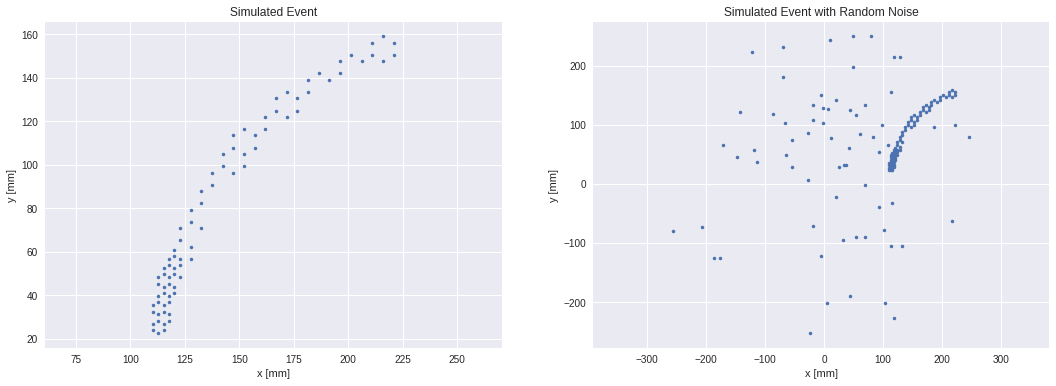

In [25]:
clean_xyzsclean_xyzsfig, ax = plt.subplots(1, 2, squeeze=True, figsize=(18, 6))

ax[0].plot(clean_xyzs[:,0], clean_xyzs[:,1], '.')
ax[0].axis('equal')
        
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[0].set_title('Simulated Event')

#######################################################################################################################
ax[1].plot(noise_xyzs[:,0], noise_xyzs[:,1], '.')
ax[1].axis('equal')
        
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')
ax[1].set_title('Simulated Event with Random Noise')

# Compare to discretized

In [26]:
DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

x_disc = 20
y_disc = 20
z_disc = 20

discElements = x_disc*y_disc*z_disc

x_inc = (2*DETECTOR_RADIUS)/x_disc
y_inc = (2*DETECTOR_RADIUS)/y_disc
z_inc = DETECTOR_LENGTH/z_disc

In [27]:
discretized_dataClean = np.zeros((1, discElements))
discretized_xyzClean = np.zeros([clean_xyzs.shape[0], clean_xyzs.shape[1]])

num_pts = 0

for point in clean_xyzs:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    
    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0        
    
#     if(discretized_dataClean[0, bucket_num] == 1):
#         print("Duplicate Found")
#         discretized_xyzClean[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
#     else:
    discretized_dataClean[0,bucket_num] = 1                  
    discretized_xyzClean[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

print("buckets filled: " + str(discretized_dataClean.sum()))

buckets filled: 11.0


In [28]:
discretized_dataNoise = np.zeros((1, discElements))
discretized_xyzNoise = np.zeros([noise_xyzs.shape[0], noise_xyzs.shape[1]])

num_pts = 0

for point in noise_xyzs:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    discretized_dataNoise[0,bucket_num] = 1

    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0                          
        
    discretized_xyzNoise[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

print("buckets filled: " + str(discretized_dataNoise.sum()))

buckets filled: 77.0


In [29]:
print(discretized_xyzClean)
#discretized_data_sparse_CHARGE  = sp.sparse.csr_matrix((discretized_xyzClean), shape=(1, discElements))

[[  1.23750000e+02   1.37500000e+01   1.75000000e+02   2.00000000e+00
    8.27000000e+02]
 [  1.23750000e+02   1.37500000e+01   1.75000000e+02   7.96136775e+00
    8.30000000e+02]
 [  1.23750000e+02   1.37500000e+01   1.75000000e+02   7.96136775e+00
    8.32000000e+02]
 [  1.23750000e+02   1.37500000e+01   1.75000000e+02   7.96136775e+00
    1.11200000e+03]
 [  1.23750000e+02   4.12500000e+01   1.75000000e+02   7.95567991e+00
    1.11300000e+03]
 [  1.23750000e+02   4.12500000e+01   1.75000000e+02   8.18459803e+01
    1.11400000e+03]
 [  1.23750000e+02   4.12500000e+01   1.75000000e+02   1.29843860e+02
    1.11500000e+03]
 [  1.23750000e+02   4.12500000e+01   1.75000000e+02   1.26880098e+02
    1.11600000e+03]
 [  1.23750000e+02   1.37500000e+01   1.75000000e+02   7.16924005e+01
    1.11700000e+03]
 [  1.23750000e+02   4.12500000e+01   1.75000000e+02   1.09613677e+01
    1.11800000e+03]
 [  1.23750000e+02   4.12500000e+01   1.75000000e+02   1.59227355e+01
    1.11900000e+03]
 [  1.2375

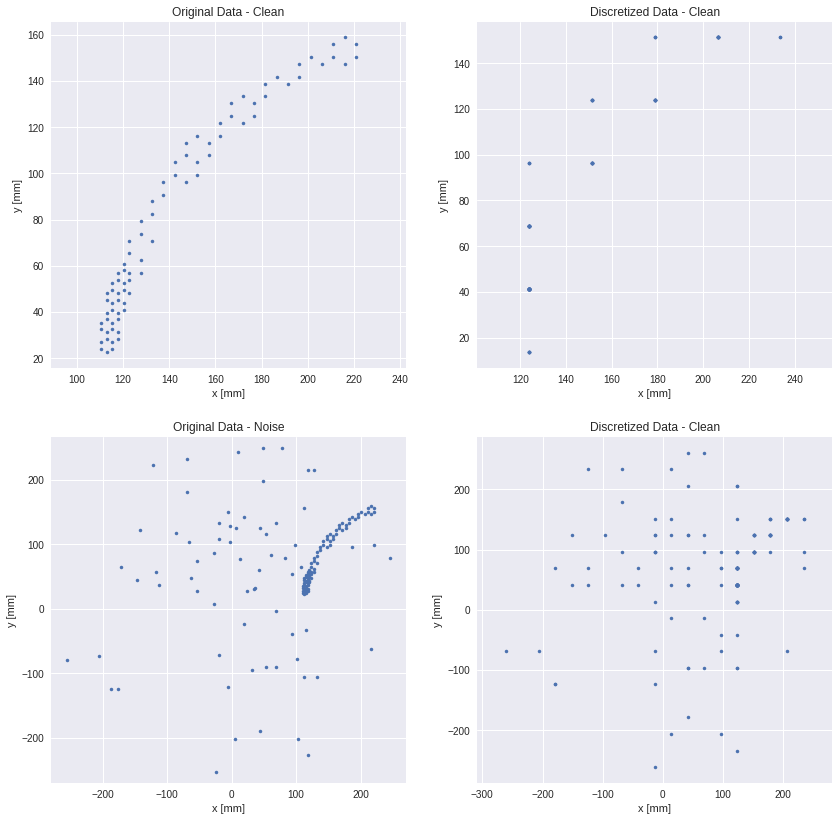

In [30]:
fig, ax = plt.subplots(2, 2, squeeze=True, figsize=(14, 14))

ax[0][0].plot(clean_xyzs[:,0], clean_xyzs[:,1], '.')
ax[0][0].axis('equal')
        
ax[0][0].set_xlabel('x [mm]')
ax[0][0].set_ylabel('y [mm]')
ax[0][0].set_title('Original Data - Clean')

#######################################################################################################################
ax[0][1].plot(discretized_xyzClean[:,0], discretized_xyzClean[:,1], '.')
ax[0][1].axis('equal')
        
ax[0][1].set_xlabel('x [mm]')
ax[0][1].set_ylabel('y [mm]')
ax[0][1].set_title('Discretized Data - Clean')

#######################################################################################################################
ax[1][0].plot(noise_xyzs[:,0], noise_xyzs[:,1], '.')
ax[1][0].axis('equal')
        
ax[1][0].set_xlabel('x [mm]')
ax[1][0].set_ylabel('y [mm]')
ax[1][0].set_title('Original Data - Noise')

#######################################################################################################################
ax[1][1].plot(discretized_xyzNoise[:,0], discretized_xyzNoise[:,1], '.')
ax[1][1].axis('equal')
        
ax[1][1].set_xlabel('x [mm]')
ax[1][1].set_ylabel('y [mm]')
ax[1][1].set_title('Discretized Data - Clean')

#plt.savefig('/home/taylor/Documents/independent-research/plots/events/noiseComparisonXY.pdf')

In [142]:
ch_colors = sns.cubehelix_palette(n_colors=6, start=0, rot=-0.4,
                                  gamma=1, hue=1, light=0.75, dark=0.1)
ch_cm = sns.blend_palette(ch_colors, as_cmap=True)

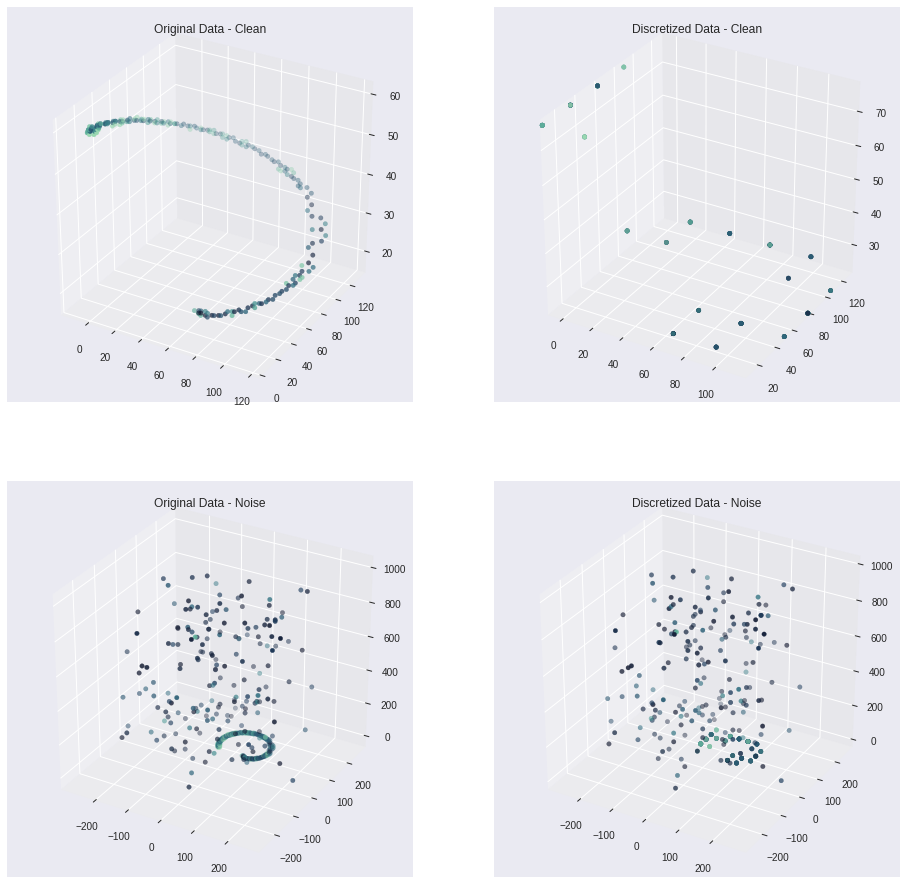

In [146]:
fig = plt.figure(figsize=(16, 16))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(clean_xyzs[:,0], clean_xyzs[:,1], clean_xyzs[:,2], cmap=ch_cm, norm=LogNorm(), c=clean_xyzs[:,3])
ax.axis('equal')
ax.set_title("Original Data - Clean")

#######################################################################################################################
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(discretized_xyzClean[:,0], discretized_xyzClean[:,1], discretized_xyzClean[:,2], cmap=ch_cm, norm=LogNorm(), c=discretized_xyzClean[:,3])
ax.axis('equal')
ax.set_title('Discretized Data - Clean')

#######################################################################################################################
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.scatter(noise_xyzs[:,0], noise_xyzs[:,1], noise_xyzs[:,2], cmap=ch_cm, norm=LogNorm(), c=noise_xyzs[:,3])
ax.axis('equal')
ax.set_title('Original Data - Noise')

############################clean_xyzs###########################################################################################
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.scatter(discretized_xyzNoise[:,0], discretized_xyzNoise[:,1], discretized_xyzNoise[:,2], cmap=ch_cm, norm=LogNorm(), c=discretized_xyzNoise[:,3])
ax.axis('equal')
ax.set_title('Discretized Data - Noise')

#plt.savefig('/home/taylor/Documents/independent-research/plots/events/noiseComparison3D.pdf')

# pad num -> xy

In [86]:
nums = np.random.randint(0,10240, (num_noisepts, 1))

In [87]:
pads = pytpc.generate_pad_plane()
pcenters = pads.mean(1)

In [88]:
xys = pcenters[nums]

In [89]:
print(xys)

[[[  9.32564678e+01   3.12053464e+01]]

 [[ -2.20870582e+02   1.16353940e+02]]

 [[  5.39905866e+01   6.23090928e+01]]

 [[ -1.47247054e+02   1.13384702e+02]]

 [[ -1.42338819e+02   3.68728882e+01]]

 [[  2.50319993e+02  -4.83434384e+01]]

 [[  2.45411757e+02  -9.08500016e+01]]

 [[ -1.57063525e+02   2.09868379e+02]]

 [[ -3.43576460e+01   1.55891265e+02]]

 [[  1.86512936e+02   1.13384702e+02]]

 [[ -4.66282339e+01  -9.95206476e+00]]

 [[  8.34399975e+01   1.67361816e+02]]

 [[ -6.13529394e+01   8.35623744e+01]]

 [[  2.45411757e+00  -1.55518732e+01]]

 [[ -2.35595287e+02  -1.07852627e+02]]

 [[  1.47247054e+01   6.52105970e+01]]

 [[ -2.15962347e+02  -1.24855252e+02]]

 [[ -1.15343526e+02  -1.55518732e+01]]

 [[ -8.83482327e+01   9.92158476e+01]]

 [[  2.45411757e+00  -3.54560027e+01]]

 [[  6.38070569e+01   2.79990422e+00]]

 [[  1.71788230e+02   1.04883389e+02]]

 [[ -2.45411757e+01  -3.68051548e+01]]

 [[ -4.90823515e+00   5.38077801e+01]]

 [[  1.52155290e+02   6.53460637e+01]]



In [90]:
print(xys.reshape(xys.shape[0], 2).shape)

(191, 2)
